[Chapter 2] Denoising and Detoning

In [11]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize

import matplotlib.pyplot as plt

The Marcenko-Pastur Theorem

<Axes: >

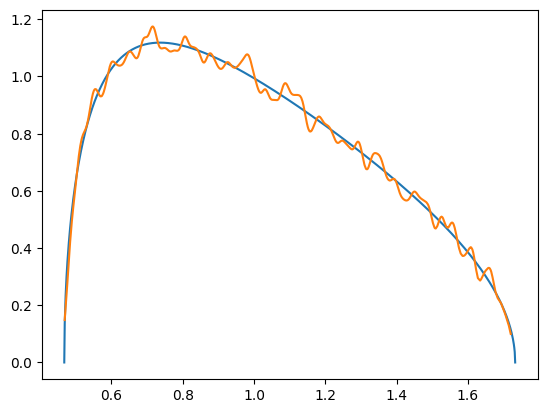

In [42]:
def mpPDF(var, q, pts):
    """
    Compute the Marcenko-Pastur probability density function (PDF).
    
    Parameters:
    - var: Variance of the underlying process (generating observations X)
    - q: Ratio T/N where X is of size TxN (T observations, N features)
    - pts: Number of points to evaluate the PDF at
    
    Returns:
    - pandas Series containing the PDF values, indexed by eigenvalues
    
    Notes:
    - The MP law describes the asymptotic distribution of eigenvalues of random correlation matrices
    - For q < 1, the distribution has a point mass at 0 with weight 1-q
    """
    # Calculate minimum and maximum eigenvalues
    eMin = var * (1 - (1./q)**0.5)**2
    eMax = var * (1 + (1./q)**0.5)**2
    
    # Generate eigenvalues (lambda) between eMin and eMax
    eVal = np.linspace(eMin, eMax, pts).flatten()
    
    # Compute Marcenko-Pastur PDF
    pdf = q/(2*np.pi*var*eVal) * ((eMax-eVal)*(eVal-eMin))**0.5
    pdf = pd.Series(pdf, index=eVal)
    
    return pdf

#---------------------------------------------------------------------------------------------------------

def getPCA(matrix, sort_descending=True):
    """
    Compute eigenvalues and eigenvectors from a Hermitian matrix (typically a correlation matrix).
    
    Parameters:
    - matrix: Input Hermitian matrix (symmetric if real-valued)
    - sort_descending: Whether to sort eigenvalues in descending order (default: True)
    
    Returns:
    - eVal: Diagonal matrix of eigenvalues (sorted if sort_descending=True)
    - eVec: Matrix of corresponding eigenvectors (sorted accordingly)
    
    Notes:
    - Uses np.linalg.eigh which is specialized for Hermitian matrices
    - When matrix is a correlation matrix, eigenvalues represent explained variance
    - Output eigenvectors are normalized to unit length
    """
    # Compute eigenvalues and eigenvectors
    eVal, eVec = np.linalg.eigh(matrix)
    
    # Sort in descending order by default
    if sort_descending:
        indices = eVal.argsort()[::-1]
        eVal = eVal[indices]
        eVec = eVec[:, indices]
    
    # Create diagonal matrix of eigenvalues
    eVal = np.diagflat(eVal)
    
    return eVal, eVec

#---------------------------------------------------------------------------------------------------------

def fitKDE(obs, bWidth=.25, kernel='gaussian', x=None):
    """
    Fit Kernel Density Estimation to a series of observations.
    
    Parameters:
    - obs: Input data (1D array or 2D array-like)
    - bWidth: Bandwidth for KDE (default: 0.25)
    - kernel: Kernel type (default: 'gaussian')
    - x: Points to evaluate the KDE (if None, uses unique values from obs)
    
    Returns:
    - pandas Series with estimated PDF values indexed by x values
    """
    # Reshape if 1D array
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    
    # Fit KDE
    kde = KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    
    # Set evaluation points
    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    elif len(x.shape) == 1:
        x = x.reshape(-1, 1)
    
    # Get log probabilities and convert to PDF
    logProb = kde.score_samples(x)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())

    return pdf

#---------------------------------------------------------------------------------------------------------

# test how closely the MP distribution (blue line) explains the eigenvalues of a random matrix X (orange line)
x = np.random.normal(size=(10000, 1000))    #T=10000 N=1000
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=1000)
# empirical pdf
pdf1 = fitKDE(np.diag(eVal0), bWidth=0.01)
# display
pdf0.plot()
pdf1.plot()

Random Matrix with Signal

In [ ]:
def getRndCov(nCols, nFacts):
    """
    Generate a random covariance matrix by combining factor structure with idiosyncratic noise.
    
    Parameters:
    - nCols: Number of columns/dimensions (features)
    - nFacts: Number of underlying factors (must be <= nCols)
    
    Returns:
    - cov: Positive semi-definite covariance matrix (nCols × nCols)
    
    Construction:
    1. Creates low-rank factor structure: W @ W.T where W ~ N(0,1)
    2. Adds full-rank diagonal noise: diag(U[0,1]))
    """
    # Factor loadings matrix (nCols × nFacts)
    w = np.random.normal(size=(nCols, nFacts))

    # Low-rank covariance from factors
    cov = np.dot(w, w.T)

    # Add full-rank diagonal noise
    cov += np.diag(np.random.uniform(size=nCols))

    return cov

#---------------------------------------------------------------------------------------------------------

def cov2corr(cov):
    """derive the correlation matrix from a covariance matrix"""
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std, std)
    corr[corr<-1], corr[corr>1] = -1 , 1 # numerical error
    return corr

#---------------------------------------------------------------------------------------------------------

alpha, nCols, nFacts, q = .995, 1000, 100, 10
cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0)
cov = alpha*cov + (1-alpha)*getRndCov(nCols, nFacts)     # noise + signal
corr0 = cov2corr(cov)
eVal0, eVec0 = getPCA(corr0)

Fitting the MP Distribution

100
0.6771508793828209


<Axes: >

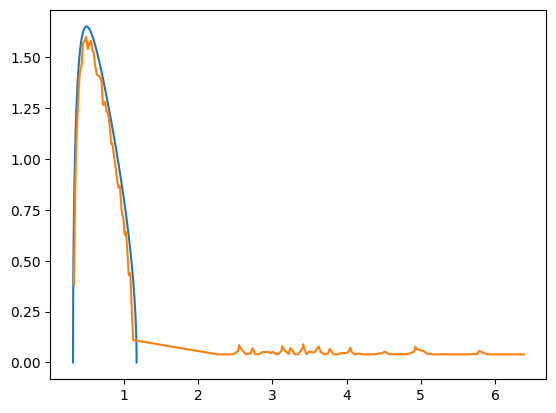

In [ ]:
def errPDFs(var, eVal, q, bWidth, pts=1000):
    """
    fit error
    """
    # theorectical pdf
    pdf0 = mpPDF(var, q, pts)
    
    # empirical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)

    # sum of the squared differences
    sse = np.sum((pdf1-pdf0)**2)

    return sse

#---------------------------------------------------------------------------------------------------------

def findMaxEval(eVal, q, bWidth):
    """
    find max random eVal by fitting MP dist
    """
    out = minimize(lambda *x: errPDFs(*x), .5, args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
    if out['success']: var=out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var

#---------------------------------------------------------------------------------------------------------
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

pdf0 = mpPDF(var0, q, 1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=0.01)

# display
print(nFacts0)  # 100 factors for fittedas we input
print(var0)     # fitted mp distribution implies sigma^2=0.677 (i.e. only about 32% of the variance can be attributed to signal)

pdf0.plot() # theorectical pdf
pdf1.plot() # empirical pdf (eigenvalues to the right of the fitted blue MP curve cannot be associated with noise, they are signal)

Denoising by Constant Residual Eigenvalue